<a href="https://colab.research.google.com/github/codened/DataStorm-4.0/blob/main/stormingRound/DataStorm_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.dtreeg" alt="Open In Colab"/></a>

Path 
stormingRound/DataStorm_4_0.ipynb

# Import necessary libraries

In [251]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Importing Data Sets

In [252]:
rawHisTransDF=pd.read_csv('Historical-transaction-data.csv')
rawStoreInfDF=pd.read_csv('Store-info.csv')
rawTestDF=pd.read_csv('Testing-data.csv')

#### Viewing Dataframe

In [253]:
rawHisTransDF.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


In [254]:
rawStoreInfDF.head()

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low


# Data Pre Processing

### Fixing Data

In [255]:
# convert the date string column to datetime
rawHisTransDF['transaction_date'] = pd.to_datetime(rawHisTransDF['transaction_date'], format='%Y/%m/%d').dt.date

In [256]:
# Performing left join
merged_df = pd.merge(rawHisTransDF, rawStoreInfDF, on='shop_id', how='left')

In [257]:
rawHisTransDF.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_description,438046,37,GINGER BEER 1.5L,59864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transaction_date,473974,62,2021-12-11,15125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice_id,467654.0,NaN,NaN,NaN,1996684.006321,1344594.276666,17.0,1032113.75,2032996.0,3032568.25,8331754.0
customer_id,473974,191636,RX33,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shop_id,473974,124,SHOP043,6631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_price,473974.0,NaN,NaN,NaN,206.689734,166.764732,35.0,100.0,200.0,220.0,17400.0
quantity_sold,473974.0,NaN,NaN,NaN,1.925506,1.634535,-1.0,1.0,2.0,2.0,101.0


In [258]:
# get count of null values in each column
null_counts = merged_df.isnull().sum()
# print the counts
print(null_counts)

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
shop_area_sq_ft         0
shop_profile        86633
dtype: int64


In [259]:
merged_df.dropna(subset=['item_description','invoice_id'], inplace=True)

In [260]:
# get count of null values in each column
null_counts = merged_df.isnull().sum()
# print the counts
print(null_counts)

item_description        0
transaction_date        0
invoice_id              0
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
shop_area_sq_ft         0
shop_profile        79471
dtype: int64


### Encoding 

In [261]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged_df['item_description'] = le.fit_transform(merged_df['item_description'])
merged_df['customer_id'] = le.fit_transform(merged_df['customer_id'])

In [262]:
merged_df['shop_id'] = merged_df['shop_id'].str.replace(r'^SHOP', '').astype(int)

C:\Users\DELL\AppData\Local\Temp\ipykernel_12748\2624828608.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['shop_id'] = merged_df['shop_id'].str.replace(r'^SHOP', '').astype(int)


In [263]:
merged_df['shop_profile'] = merged_df['shop_profile'].replace({'High': 1, 'Moderate': 2, 'Low': 3})
merged_df['shop_profile'] = merged_df['shop_profile'].fillna(0.0).astype(int)
merged_df['invoice_id'] = merged_df['invoice_id'].astype(int)

In [264]:
merged_df


,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,27,2021-12-11,147,57272,8,220,2,678,2
1,14,2021-10-17,371,91334,112,220,2,668,2
2,35,2021-12-13,484,158179,8,160,2,678,2
3,4,2021-12-13,484,158179,8,150,2,678,2
4,34,2021-10-23,1310,38862,112,210,5,668,2
...,...,...,...,...,...,...,...,...,...
473820,13,2021-11-14,8014206,176899,3,60,2,810,1
473821,1,2021-10-16,8304754,52159,127,35,2,848,1
473822,14,2021-10-16,8304807,95280,127,220,1,848,1
473823,1,2021-11-07,8313570,8748,127,35,1,848,1


# Feature Engineering

## 

In [265]:
print(merged_df[merged_df['quantity_sold'] == 0])

        item_description transaction_date  invoice_id  customer_id  shop_id  \
54                     5       2021-12-09       24423        70620        3   
103                   32       2021-10-31       31745       177679       90   
230                    3       2021-12-10       52904        26069       40   
273                   24       2021-11-12       59336       154510      103   
465                   22       2021-11-10      111021       100682       32   
...                  ...              ...         ...          ...      ...   
473258                 5       2021-12-04     4363428       108185      113   
473355                32       2021-11-21     4479312       154031       62   
473412                 0       2021-11-13     4603720        68657       58   
473462                35       2021-12-10     4653601        63057       77   
473500                11       2021-10-27     4798624        37513      127   

        item_price  quantity_sold  shop_area_sq_ft 

In [266]:
merged_df = merged_df[merged_df['quantity_sold'] != 0]
print(merged_df)

        item_description transaction_date  invoice_id  customer_id  shop_id  \
0                     27       2021-12-11         147        57272        8   
1                     14       2021-10-17         371        91334      112   
2                     35       2021-12-13         484       158179        8   
3                      4       2021-12-13         484       158179        8   
4                     34       2021-10-23        1310        38862      112   
...                  ...              ...         ...          ...      ...   
473820                13       2021-11-14     8014206       176899        3   
473821                 1       2021-10-16     8304754        52159      127   
473822                14       2021-10-16     8304807        95280      127   
473823                 1       2021-11-07     8313570         8748      127   
473824                 3       2021-12-02     8325631        11566      127   

        item_price  quantity_sold  shop_area_sq_ft 

# Split To Test and Train Data

In [267]:
# Split the DataFrame into two based on column B
TestDF = merged_df[merged_df['shop_profile'] == 0].drop(['shop_profile'], axis=1)
TrainDF = merged_df[merged_df['shop_profile'] != 0]

In [268]:
# Split Fulldata into training and testing sets
from sklearn.model_selection import train_test_split

column_name = 'shop_id'
unique_categories = TrainDF[column_name].nunique()
categories_in_dataset_1 = int(unique_categories * 0.8)
categories_in_dataset_2 = unique_categories - categories_in_dataset_1
dataset_1_categories = TrainDF[column_name].unique()[:categories_in_dataset_1]
dataset_2_categories = TrainDF[column_name].unique()[categories_in_dataset_1:]

train_data = TrainDF[TrainDF[column_name].isin(dataset_1_categories)]
test_data = TrainDF[TrainDF[column_name].isin(dataset_2_categories)]





#train_data, test_data = train_test_split(TrainDF, test_size=0.01)

#### Random Forest

In [269]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


X_train=train_data.drop(['shop_profile','transaction_date'], axis=1)
y_train=train_data['shop_profile']
X_test= test_data.drop(['shop_profile','transaction_date'], axis=1)
y_test=test_data['shop_profile']

# Define the logistic regression model
model = RandomForestClassifier()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

accu = accuracy_score(y_test, predictions)

print(accu)
# print(f1_score(y_test, predictions, average=None))



0.552602478551001


In [270]:
expectedResult=test_data[['shop_id','shop_profile']]
print(expectedResult)

        shop_id  shop_profile
2080         20             2
2081         20             2
2082        100             2
2083        100             2
2084        100             2
...         ...           ...
473818       72             1
473821      127             1
473822      127             1
473823      127             1
473824      127             1

[78675 rows x 2 columns]


In [271]:
unique_values = expectedResult['shop_id'].nunique()

print(unique_values)

20


In [272]:
predDf=pd.DataFrame(predictions, columns=['shop_profile'])

In [273]:
X_test

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft
2080,32,435236,149483,20,70,2,617
2081,17,435287,168797,20,100,1,617
2082,27,435336,70012,100,440,3,617
2083,3,435336,70012,100,220,1,617
2084,27,435383,39687,100,220,2,617
...,...,...,...,...,...,...,...
473818,1,7030820,124346,72,35,1,617
473821,1,8304754,52159,127,35,2,848
473822,14,8304807,95280,127,220,1,848
473823,1,8313570,8748,127,35,1,848


In [274]:
X_testres = X_test.reset_index(drop=True)

In [275]:
X_testres

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft
0,32,435236,149483,20,70,2,617
1,17,435287,168797,20,100,1,617
2,27,435336,70012,100,440,3,617
3,3,435336,70012,100,220,1,617
4,27,435383,39687,100,220,2,617
...,...,...,...,...,...,...,...
78670,1,7030820,124346,72,35,1,617
78671,1,8304754,52159,127,35,2,848
78672,14,8304807,95280,127,220,1,848
78673,1,8313570,8748,127,35,1,848


In [276]:
# Concatenate DataFrames
concatenatedRes_df = pd.concat([X_testres, predDf], axis=1)

In [277]:
concatenatedRes_df

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,32,435236,149483,20,70,2,617,1
1,17,435287,168797,20,100,1,617,1
2,27,435336,70012,100,440,3,617,3
3,3,435336,70012,100,220,1,617,3
4,27,435383,39687,100,220,2,617,3
...,...,...,...,...,...,...,...,...
78670,1,7030820,124346,72,35,1,617,1
78671,1,8304754,52159,127,35,2,848,1
78672,14,8304807,95280,127,220,1,848,1
78673,1,8313570,8748,127,35,1,848,1


In [278]:
ResMode_df = concatenatedRes_df.groupby('shop_id')['shop_profile'].agg(pd.Series.mode)

In [279]:
ResMode_df

shop_id
6      3
16     1
20     1
31     3
33     1
35     2
39     2
48     3
57     2
58     3
69     3
72     3
77     1
82     3
100    3
101    3
113    2
117    2
126    1
127    1
Name: shop_profile, dtype: int32

In [280]:
TestMode_df = expectedResult.groupby('shop_id')['shop_profile'].agg(pd.Series.mode)

In [281]:
TestMode_df

shop_id
6      3
16     1
20     2
31     2
33     1
35     2
39     2
48     2
57     2
58     1
69     3
72     1
77     1
82     1
100    2
101    1
113    2
117    3
126    2
127    1
Name: shop_profile, dtype: int32

In [282]:
# Calculate F1 score for each class
f1_class0 = f1_score(TestMode_df, ResMode_df, labels=[1], average='weighted')
f1_class1 = f1_score(TestMode_df, ResMode_df, labels=[2], average='weighted')
f1_class2 = f1_score(TestMode_df, ResMode_df, labels=[3], average='weighted')

# Calculate average F1 score
f1_average = (f1_class0 + f1_class1 + f1_class2) / 3

print(f"F1 score for class 0: {f1_class0:.2f}")
print(f"F1 score for class 1: {f1_class1:.2f}")
print(f"F1 score for class 2: {f1_class2:.2f}")
print(f"Average F1 score: {f1_average:.2f}")

F1 score for class 0: 0.57
F1 score for class 1: 0.57
F1 score for class 2: 0.33
Average F1 score: 0.49


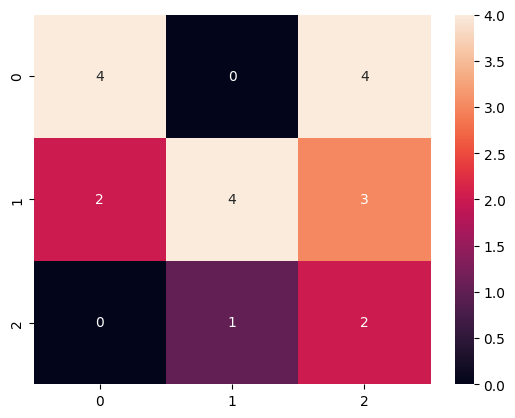

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
matrix = confusion_matrix(TestMode_df, ResMode_df)

# Visualize confusion matrix
sns.heatmap(matrix, annot=True)
plt.show()

#### Logistic Regression

In [284]:
from sklearn.linear_model import LogisticRegression

# Initialize and train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions_logr = model.predict(X_test)

accu = accuracy_score(y_test, predictions_logr)

print(accu)

0.37698125198601845


In [285]:
predDf_logr=pd.DataFrame(predictions_logr, columns=['shop_profile'])

In [286]:
# Concatenate DataFrames
concatenatedRes_df_logr = pd.concat([X_testres, predDf_logr], axis=1)

In [287]:
ResMode_df_logr = concatenatedRes_df_logr.groupby('shop_id')['shop_profile'].agg(pd.Series.mode)

In [288]:
# Calculate F1 score for each class
f1_class0 = f1_score(TestMode_df, ResMode_df_logr, labels=[1], average='weighted')
f1_class1 = f1_score(TestMode_df, ResMode_df_logr, labels=[2], average='weighted')
f1_class2 = f1_score(TestMode_df, ResMode_df_logr, labels=[3], average='weighted')

# Calculate average F1 score
f1_average = (f1_class0 + f1_class1 + f1_class2) / 3

print(f"F1 score for class 0: {f1_class0:.2f}")
print(f"F1 score for class 1: {f1_class1:.2f}")
print(f"F1 score for class 2: {f1_class2:.2f}")
print(f"Average F1 score: {f1_average:.2f}")

F1 score for class 0: 0.80
F1 score for class 1: 0.00
F1 score for class 2: 0.55
Average F1 score: 0.45


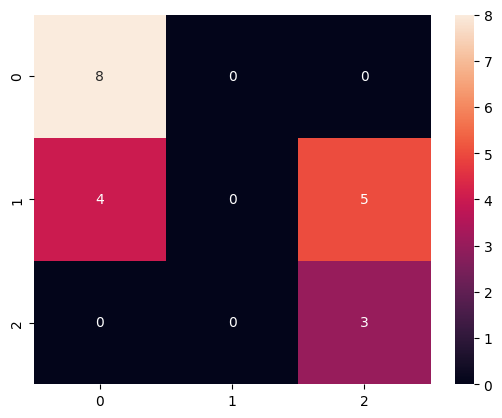

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
matrix = confusion_matrix(TestMode_df, ResMode_df_logr)

# Visualize confusion matrix
sns.heatmap(matrix, annot=True)
plt.show()

#### Decision Tree

In [291]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions_dtree = model.predict(X_test)

accu = accuracy_score(y_test, predictions_dtree)

print(accu)

0.5829806164601208


F1 score for class 0: 0.67
F1 score for class 1: 0.57
F1 score for class 2: 0.36
Average F1 score: 0.53


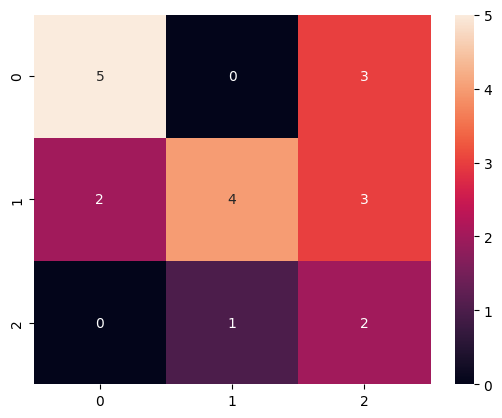

In [292]:
predDf_dtree=pd.DataFrame(predictions_dtree, columns=['shop_profile'])
# Concatenate DataFrames
concatenatedRes_df_dtree = pd.concat([X_testres, predDf_dtree], axis=1)
ResMode_df_dtree = concatenatedRes_df_dtree.groupby('shop_id')['shop_profile'].agg(pd.Series.mode)

# Calculate F1 score for each class
f1_class0 = f1_score(TestMode_df, ResMode_df_dtree, labels=[1], average='weighted')
f1_class1 = f1_score(TestMode_df, ResMode_df_dtree, labels=[2], average='weighted')
f1_class2 = f1_score(TestMode_df, ResMode_df_dtree, labels=[3], average='weighted')

# Calculate average F1 score
f1_average = (f1_class0 + f1_class1 + f1_class2) / 3

print(f"F1 score for class 0: {f1_class0:.2f}")
print(f"F1 score for class 1: {f1_class1:.2f}")
print(f"F1 score for class 2: {f1_class2:.2f}")
print(f"Average F1 score: {f1_average:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
matrix = confusion_matrix(TestMode_df, ResMode_df_dtree)

# Visualize confusion matrix
sns.heatmap(matrix, annot=True)
plt.show()

#### Support Vector

In [293]:
from sklearn.svm import SVC

# Initialize and train model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions_sv = model.predict(X_test)

accu = accuracy_score(y_test, predictions_sv)

print(accu)

In [ ]:
predDf_sv=pd.DataFrame(predictions_sv, columns=['shop_profile'])
# Concatenate DataFrames
concatenatedRes_df_sv = pd.concat([X_testres, predDf_sv], axis=1)
ResMode_df_sv = concatenatedRes_df_sv.groupby('shop_id')['shop_profile'].agg(pd.Series.mode)

# Calculate F1 score for each class
f1_class0 = f1_score(TestMode_df, ResMode_df_sv, labels=[1], average='weighted')
f1_class1 = f1_score(TestMode_df, ResMode_df_sv, labels=[2], average='weighted')
f1_class2 = f1_score(TestMode_df, ResMode_df_sv, labels=[3], average='weighted')

# Calculate average F1 score
f1_average = (f1_class0 + f1_class1 + f1_class2) / 3

print(f"F1 score for class 0: {f1_class0:.2f}")
print(f"F1 score for class 1: {f1_class1:.2f}")
print(f"F1 score for class 2: {f1_class2:.2f}")
print(f"Average F1 score: {f1_average:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
matrix = confusion_matrix(TestMode_df, ResMode_df_sv)

# Visualize confusion matrix
sns.heatmap(matrix, annot=True)
plt.show()

-----------------------------------------------------------------------------------------------------------

In [ ]:
# predict for test values
Evalpredictions = model.predict(TestDF.drop(['transaction_date'], axis=1))

EvalpredictionsDF=pd.DataFrame(Evalpredictions, columns=['shop_profile'])


In [ ]:
EvalpredictionsDF

,shop_profile
0,3
1,3
2,3
3,3
4,3
...,...
78048,1
78049,1
78050,1
78051,1


In [ ]:
TestDFinReseted = TestDF.reset_index(drop=True)
# Concatenate DataFrames
concatenatedEval_df = pd.concat([TestDFinReseted['shop_id'], EvalpredictionsDF], axis=1)

In [ ]:
EvalMode_df = (concatenatedEval_df.groupby('shop_id')['shop_profile'].agg(pd.Series.mode)).to_frame()

In [ ]:
EvalMode_df

,shop_profile
shop_id,
2,3
19,3
23,3
24,3
29,1
30,3
38,3
44,3
46,3


In [ ]:
# Save array to CSV file
np.savetxt('EvalResult.csv', EvalMode_df, delimiter=',')


In [ ]:
UploadShid=pd.read_csv('Testing-datatoUpload.csv')


In [ ]:
UploadShid

,shop_id,shop_profile
0,SHOP046,Moderate
1,SHOP024,Low
2,SHOP023,Moderate
3,SHOP097,Moderate
4,SHOP044,Low
5,SHOP030,Moderate
6,SHOP038,Moderate
7,SHOP029,Moderate
8,SHOP096,Low
9,SHOP092,Low


In [ ]:
UploadShid['shop_profile'] = UploadShid['shop_profile'].replace({1 : 'High', 2 : 'Moderate',3 : 'Low'})

In [ ]:
UploadShid

,shop_id,shop_profile
0,SHOP046,Moderate
1,SHOP024,Low
2,SHOP023,Moderate
3,SHOP097,Moderate
4,SHOP044,Low
5,SHOP030,Moderate
6,SHOP038,Moderate
7,SHOP029,Moderate
8,SHOP096,Low
9,SHOP092,Low


In [ ]:
# Save array to CSV file
UploadShid.to_csv('Testing-datatoUpload.csv', index=False)


In [ ]:
# # Import necessary libraries
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# from sklearn.metrics import accuracy_score, confusion_matrix

# X_train=train_data.drop(['shop_profile','transaction_date'], axis=1)
# y_train=train_data['shop_profile']
# X_test= test_data.drop(['shop_profile','transaction_date'], axis=1)
# y_test=test_data['shop_profile']

# # Create a list of machine learning models to try out
# models = []
# models.append(('Logistic Regression', LogisticRegression()))
# models.append(('SVM', SVC()))
# models.append(('Decision Tree', DecisionTreeClassifier()))
# models.append(('Random Forest', RandomForestClassifier()))
# models.append(('AdaBoost', AdaBoostClassifier()))
# models.append(('Extra Trees', ExtraTreesClassifier()))
# models.append(('K-Nearest Neighbors', KNeighborsClassifier()))
# models.append(('Gaussian Naive Bayes', GaussianNB()))
# models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# models.append(('Gradient Boosting', GradientBoostingClassifier()))


# # Define the hyperparameters to tune for each model
# params = {
#     'Logistic Regression': {'C': [0.1, 1, 10]},
#     'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
#     'Decision Tree': {'max_depth': [2, 4, 6]},
#     'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [2, 4, 6]},    
#     'AdaBoost': {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200, 300]},
#     'Extra Trees': {'n_estimators': [100, 200, 300], 'max_depth': [2, 4, 6]},
#     'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
#     'Gaussian Naive Bayes': {},
#     'Linear Discriminant Analysis': {'solver': ['svd', 'lsqr']},
#     'Gradient Boosting': {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200, 300], 'max_depth': [2, 4, 6]}
# }

# # Train and evaluate each model with hyperparameter tuning
# results = []
# names = []

# accuResults=[]

# resultsxxx=[]

# for name, model in models:
#     param_grid = params[name]
#     clf = GridSearchCV(model, param_grid, cv=5)
#     clf.fit(X_train, y_train)  # Fit the GridSearchCV object to the training data
#     cv_results = cross_val_score(clf, X_train, y_train, cv=5)
#     results.append(cv_results)
#     names.append(name)

#     y_pred = clf.predict(X_test)
#     accu = accuracy_score(y_test, y_pred)
#     accuResults.append(accu)

#     resultsxxx.append(accu*cv_results)

#     print(f'{name}: cv : {cv_results.mean()}')
#     print(f'{name}: accu : {accu}')
#     print(f'Best parameters: {clf.best_params_}')  # Print the best parameters inside the loop


# # Select the best model based on mean cross-validation score
# best_idx_cv = np.argmax([np.mean(r) for r in results])
# best_model_cv = models[best_idx_cv][1]
# print(f'Best model from cv mean: {names[best_idx_cv]}')

# # Evaluate the best model on the test set
# best_model_cv.fit(X_train, y_train)
# y_pred = best_model_cv.predict(X_test)
# cv_resultscv = cross_val_score(best_model_cv, X_train, y_train, cv=5)
# print(f'CV : {cv_resultscv.mean()}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
# # Create a confusion matrix to visualize the performance of the model
# cm1 = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm1, annot=True, cmap='Blues', fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title(f'Confusion Matrix for {best_model_cv}')
# plt.show()



# # Select the best model based on mean accuracy score
# best_idx_acc = np.argmax(accuResults)
# best_model_acc = models[best_idx_acc][1]
# print(f'Best model from accue Accuracy: {names[best_idx_acc]}')

# # Evaluate the best model on the test set
# best_model_acc.fit(X_train, y_train)
# y_pred = best_model_acc.predict(X_test)
# cv_resultsAcc = cross_val_score(best_model_acc, X_train, y_train, cv=5)
# print(f'CV : {cv_resultsAcc.mean()}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# # Create a confusion matrix to visualize the performance of the model
# cm2 = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title(f'Confusion Matrix for {best_model_acc}')
# plt.show()




# # Select the best model based on mean multiplication
# best_id_mul = np.argmax(resultsxxx)
# best_model_mul = models[best_id_mul][1]
# print(f'Best model from multiplication of two: {names[best_id_mul]}')

# # Evaluate the best model on the test set
# best_model_mul.fit(X_train, y_train)
# y_pred = best_model_mul.predict(X_test)
# cv_resultsAcc = cross_val_score(best_model_mul, X_train, y_train, cv=5)
# print(f'CV : {cv_resultsAcc.mean()}')
# print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
# print(f'Mul : {cv_resultsAcc.mean()*accuracy_score(y_test, y_pred)}')

# # Create a confusion matrix to visualize the performance of the model
# cm3 = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm3, annot=True, cmap='Blues', fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title(f'Confusion Matrix for {best_model_mul}')
# plt.show()